In [49]:
from google_play_scraper import reviews, Sort
import csv
import pandas as pd
import re
import string
import nltk
import requests
from io import BytesIO
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# ***SCRAPING DATA***

In [2]:
app_id = 'com.linkdokter.halodoc.android'

def get_reviews(app_id, lang='id', count=10000, sort=Sort.NEWEST, filter_score_with=None, filter_device_with=None, continuation_token=None):
    try:
        result, continuation_token = reviews(
            app_id,
            lang=lang,
            country='id',
            sort=sort,
            count=count,
            filter_score_with=filter_score_with,
            filter_device_with=filter_device_with,
            continuation_token=continuation_token
        )

        return result, continuation_token
    except Exception as e:
        print("Error:", e)
        return None, None

reviews, continuation_token = get_reviews(app_id)

if reviews is not None:
    print("Jumlah ulasan:", len(reviews))
    if len(reviews) > 0:
        print("Contoh ulasan:")
        print(reviews[0])
else:
    print("Tidak dapat mengambil ulasan.")

Jumlah ulasan: 10000
Contoh ulasan:
{'reviewId': 'cc1e7e79-2ae0-47fc-a35b-3fe385f04703', 'userName': 'Pengguna Google', 'userImage': 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g', 'content': 'untuk pemesanan obat di kendari Sulawesi Tenggara masih banyak yang tidak tersedia. apotik rekanan halodocnya masih sedikit. di resepkan 5 obat oleh dokter yang tersedia cuman 1 obat', 'score': 1, 'thumbsUpCount': 0, 'reviewCreatedVersion': '25.100', 'at': datetime.datetime(2025, 7, 6, 12, 15, 21), 'replyContent': 'Hai Gin S3, mohon maaf atas keluhan yang dialami. Kami sedang berupaya memperbaikinya secepatnya.\n\nJika masih butuh bantuan atau ingin menindaklanjuti, mohon DM ke @HalodocID (X) atau @Halodoc (Instagram), atau email ke help@halodoc.com detail kendalamu, termasuk nomor HP akun Halodoc dan/atau nomor pesanan.\n\nTerima kasih.', 'repliedAt': datetime.datetime(2025, 7, 7, 1, 41, 38), 'appVersion': '25.100'}


In [3]:
def export_to_csv(reviews, file_name='hasil_scraper_ulasan_app_Halodoc.csv'):
    if reviews:
        fieldnames = ['Review ID', 'Username', 'Rating', 'Review Text', 'Date']

        with open(file_name, mode='w', newline='', encoding='utf-8') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()

            for review in reviews:
                writer.writerow({
                    'Review ID': review['reviewId'],
                    'Username': review['userName'],
                    'Rating': review['score'],
                    'Review Text': review['content'],
                    'Date': review['at']
                })

        print(f"Data berhasil diekspor ke '{file_name}'")
    else:
        print("Tidak ada data ulasan untuk diekspor.")

export_to_csv(reviews)

Data berhasil diekspor ke 'hasil_scraper_ulasan_app_Halodoc.csv'


In [8]:
data = pd.read_csv("hasil_scraper_ulasan_app_Halodoc.csv")

In [9]:
data

,Review ID,Username,Rating,Review Text,Date
0,cc1e7e79-2ae0-47fc-a35b-3fe385f04703,Pengguna Google,1,untuk pemesanan obat di kendari Sulawesi Tengg...,2025-07-06 12:15:21
1,610e01e3-6c81-4392-bce2-292ee92a3961,Pengguna Google,5,"sangat membantu, soalnya gak bisa kemana2 karn...",2025-07-06 09:49:32
2,a5f6c35c-4ad9-4b46-8538-08b3b1227bba,Pengguna Google,5,Dokternya sangat membantu.,2025-07-06 07:36:56
3,d6370b46-76a8-4e61-adbd-987400285e0a,Pengguna Google,5,Sangat membantu jika ada kendala waktu dan tem...,2025-07-06 06:31:36
4,71461afe-1e4c-41c9-a116-0a6557eaa36b,Pengguna Google,5,ramah ramah dokternya❤️❤️,2025-07-06 01:59:36
...,...,...,...,...,...
9995,3571eab2-62bf-4dcd-9a38-f38be56860b5,rian widi arjun,5,Sangat Bermanfaat dan Cocok untuk yang pengen ...,2023-11-01 07:32:37
9996,4d78c5f3-15bd-4c3b-849b-38e07258f11f,Andre Kwee,5,Ok,2023-11-01 07:26:25
9997,b2b2a9f0-acd0-47d4-a339-a53efdf797ba,Adi Nurzaman,5,Sangat membantu aplikasi ini,2023-10-31 22:41:23
9998,f3cb78b4-677e-4678-9f19-9877acb366ba,Ana Andreana Putra,1,Pelayanan buruk,2023-10-31 17:54:35


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review ID    10000 non-null  object
 1   Username     10000 non-null  object
 2   Rating       10000 non-null  int64 
 3   Review Text  10000 non-null  object
 4   Date         10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


# ***PREPROCESSING DATA***

In [11]:
df = pd.DataFrame(data[['Rating','Review Text']])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       10000 non-null  int64 
 1   Review Text  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [13]:
df.head()

,Rating,Review Text
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn..."
2,5,Dokternya sangat membantu.
3,5,Sangat membantu jika ada kendala waktu dan tem...
4,5,ramah ramah dokternya❤️❤️


**Proses Hapus Data Duplikat**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       10000 non-null  int64 
 1   Review Text  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [15]:
df.drop_duplicates(subset ="Review Text", keep = 'first', inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7332 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       7332 non-null   int64 
 1   Review Text  7332 non-null   object
dtypes: int64(1), object(1)
memory usage: 171.8+ KB


In [18]:
# Fungsi untuk menghapus URL
def remove_URL(tweet):
    if tweet is not None and isinstance(tweet, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus HTML
def remove_html(tweet):
    if tweet is not None and isinstance(tweet, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001F004-\U0001F0CF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    return tweet

# Fungsi untuk menghapus angka
def remove_numbers(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'\d', '', tweet)
    return tweet

# Fungsi hapus username
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

df['cleaning'] = df['Review Text'].apply(lambda x: remove_URL(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_usernames(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_html(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_emoji(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_symbols(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_numbers(x))

In [19]:
df.head()

,Rating,Review Text,cleaning
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya


**Proses Case Folding**

In [20]:
def case_folding(text):
    if isinstance(text, str):
        lowercase_text = text.lower()
        return lowercase_text
    else:
        return text

df['case_folding'] = df['cleaning'].apply(case_folding)

In [21]:
df.head()

,Rating,Review Text,cleaning,case_folding
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya


**Normalisasi Kata**

In [23]:
# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

# Baca dataset kamu (pastikan df sudah tersedia)
data = pd.DataFrame(df[['Rating','Review Text','cleaning','case_folding']])

In [24]:
data.head()

,Rating,Review Text,cleaning,case_folding
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya


In [25]:
# Unduh dan baca kamus dari GitHub
url = "https://github.com/analysisdatasentiment/kamus_kata_baku/raw/main/kamuskatabaku.xlsx"
response = requests.get(url)
file_excel = BytesIO(response.content)
kamus_data = pd.read_excel(file_excel)

# Buat dictionary dari kamus
kamus_tidak_baku_dict = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [26]:
# Terapkan fungsi normalisasi
data[['normalisasi', 'Kata_Baku', 'Kata_Tidak_Baku', 'Kata_Tidak_Baku_Hash']] = data['case_folding'].apply(
    lambda x: pd.Series(replace_taboo_words(x, kamus_tidak_baku_dict))
)

# Ambil kolom yang relevan
df = pd.DataFrame(data[['Rating','Review Text','cleaning','case_folding','normalisasi']])

In [27]:
df.head()

,Rating,Review Text,cleaning,case_folding,normalisasi
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...,untuk pemesanan obat di kendari sulawesi tengg...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya tidak bisa kemana kare...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu,dokternya sangat membantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya,ramah ramah dokternya


**Tokenization**

In [28]:
def tokenize(text):
    tokens = text.split()
    return tokens

df['tokenize'] = df['normalisasi'].apply(tokenize)

In [29]:
df.head()

,Rating,Review Text,cleaning,case_folding,normalisasi,tokenize
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...,untuk pemesanan obat di kendari sulawesi tengg...,"[untuk, pemesanan, obat, di, kendari, sulawesi..."
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya tidak bisa kemana kare...,"[sangat, membantu, soalnya, tidak, bisa, keman..."
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu,dokternya sangat membantu,"[dokternya, sangat, membantu]"
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,"[sangat, membantu, jika, ada, kendala, waktu, ..."
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya,ramah ramah dokternya,"[ramah, ramah, dokternya]"


**Proses Stopword Removal**

In [31]:
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hafizh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['stopword removal'] = df['tokenize'].apply(lambda x: remove_stopwords(x))

df.head()

,Rating,Review Text,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...,untuk pemesanan obat di kendari sulawesi tengg...,"[untuk, pemesanan, obat, di, kendari, sulawesi...","[pemesanan, obat, kendari, sulawesi, tenggara,..."
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya tidak bisa kemana kare...,"[sangat, membantu, soalnya, tidak, bisa, keman...","[membantu, kemana, sakit, untungnya, halodoc, ..."
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu,dokternya sangat membantu,"[dokternya, sangat, membantu]","[dokternya, membantu]"
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,"[sangat, membantu, jika, ada, kendala, waktu, ...","[membantu, kendala, berkonsuktas, dokter, tata..."
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya,ramah ramah dokternya,"[ramah, ramah, dokternya]","[ramah, ramah, dokternya]"


**Proses Steaming Data**

In [34]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return [stemmer.stem(word) for word in text]

df['steming_data'] = df['stopword removal'].apply(lambda x: ' '.join(stem_text(x)))
df.head()

,Rating,Review Text,cleaning,case_folding,normalisasi,tokenize,stopword removal,steming_data
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...,untuk pemesanan obat di kendari sulawesi tengg...,"[untuk, pemesanan, obat, di, kendari, sulawesi...","[pemesanan, obat, kendari, sulawesi, tenggara,...",mesan obat kendari sulawesi tenggara sedia apo...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya tidak bisa kemana kare...,"[sangat, membantu, soalnya, tidak, bisa, keman...","[membantu, kemana, sakit, untungnya, halodoc, ...",bantu mana sakit untung halodoc bantu kasih sa...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu,dokternya sangat membantu,"[dokternya, sangat, membantu]","[dokternya, membantu]",dokter bantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,"[sangat, membantu, jika, ada, kendala, waktu, ...","[membantu, kendala, berkonsuktas, dokter, tata...",bantu kendala berkonsuktas dokter tatap muka
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya,ramah ramah dokternya,"[ramah, ramah, dokternya]","[ramah, ramah, dokternya]",ramah ramah dokter


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7332 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rating            7332 non-null   int64 
 1   Review Text       7332 non-null   object
 2   cleaning          7332 non-null   object
 3   case_folding      7332 non-null   object
 4   normalisasi       7332 non-null   object
 5   tokenize          7332 non-null   object
 6   stopword removal  7332 non-null   object
 7   steming_data      7332 non-null   object
dtypes: int64(1), object(7)
memory usage: 515.5+ KB


**Proses Hapus Data Bernilai Kosong (nan)**

In [36]:
data = df.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7332 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rating            7332 non-null   int64 
 1   Review Text       7332 non-null   object
 2   cleaning          7332 non-null   object
 3   case_folding      7332 non-null   object
 4   normalisasi       7332 non-null   object
 5   tokenize          7332 non-null   object
 6   stopword removal  7332 non-null   object
 7   steming_data      7332 non-null   object
dtypes: int64(1), object(7)
memory usage: 515.5+ KB


**Wordcloud Setelah Preprocessing**

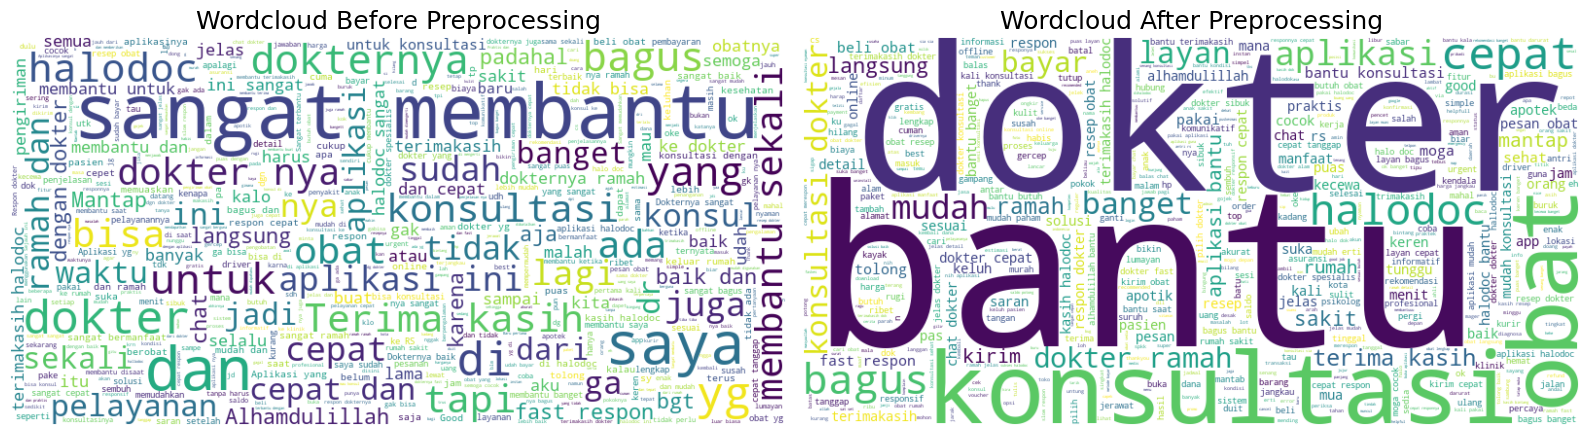

In [39]:
# Buat stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp','lu','deh','fyp', 'ya', 'gue', 'sih','update','apk'])

# WordCloud Before (dari kolom 'Review Text')
text_before = ' '.join(data['Review Text'].astype(str).tolist())
wc_before = WordCloud(stopwords=stopwords, background_color="white", max_words=500, width=800, height=400).generate(text_before)

# WordCloud After (dari kolom 'steming_data')
text_after = ' '.join(data['steming_data'].astype(str).tolist())
wc_after = WordCloud(stopwords=stopwords, background_color="white", max_words=500, width=800, height=400).generate(text_after)

# Visualisasi side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_before, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Before Preprocessing", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_after, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud After Preprocessing", fontsize=18)

plt.tight_layout()
plt.show()


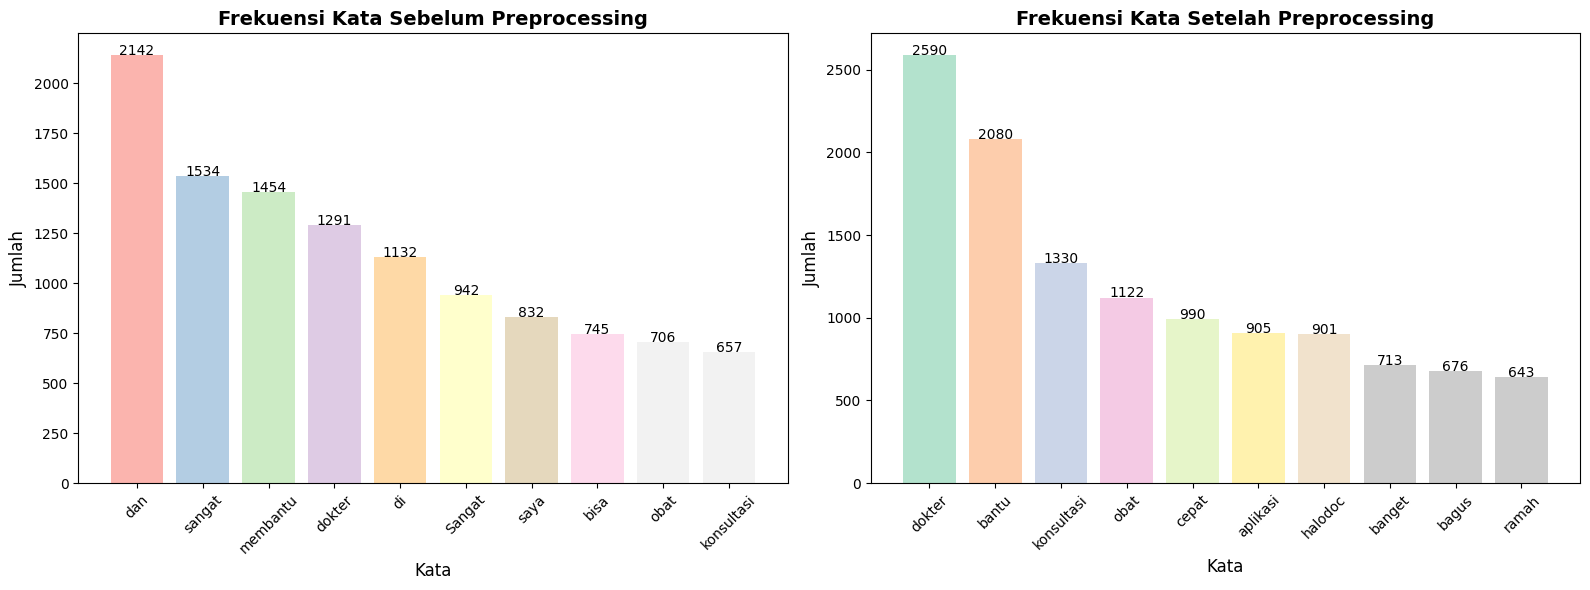

In [41]:
# Set stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu', 'deh', 'fyp', 'ya', 'gue',
                  'sih', 'yg', 'nya', 'aja', 'sdh', 'gak', 'ga','update','apk'])

# BEFORE: kolom 'Review Text'
all_text_before = ' '.join(data["Review Text"].astype(str))
words_before = all_text_before.split()
filtered_words_before = [word for word in words_before if word.lower() not in stopwords]
word_counts_before = Counter(filtered_words_before)
top_words_before = word_counts_before.most_common(10)
word_before, count_before = zip(*top_words_before)

# AFTER: kolom 'steming_data'
all_text_after = ' '.join(data["steming_data"].astype(str))
words_after = all_text_after.split()
filtered_words_after = [word for word in words_after if word.lower() not in stopwords]
word_counts_after = Counter(filtered_words_after)
top_words_after = word_counts_after.most_common(10)
word_after, count_after = zip(*top_words_after)

# Plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BEFORE Plot
colors_before = plt.cm.Pastel1(range(len(word_before)))
bars1 = axes[0].bar(word_before, count_before, color=colors_before)
axes[0].set_title("Frekuensi Kata Sebelum Preprocessing", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Kata", fontsize=12)
axes[0].set_ylabel("Jumlah", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars1, count_before):
    axes[0].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

# AFTER Plot
colors_after = plt.cm.Pastel2(range(len(word_after)))
bars2 = axes[1].bar(word_after, count_after, color=colors_after)
axes[1].set_title("Frekuensi Kata Setelah Preprocessing", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Kata", fontsize=12)
axes[1].set_ylabel("Jumlah", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars2, count_after):
    axes[1].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()

In [42]:
df.to_csv('Hasil_Preprocessing_Data.csv',encoding='utf8', index=False)

# ***PELEBALAN DATA METODE LAXICON BASED***

In [43]:
data = pd.read_csv("Hasil_Preprocessing_Data.csv")

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7332 entries, 0 to 7331
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rating            7332 non-null   int64 
 1   Review Text       7332 non-null   object
 2   cleaning          7300 non-null   object
 3   case_folding      7300 non-null   object
 4   normalisasi       7295 non-null   object
 5   tokenize          7332 non-null   object
 6   stopword removal  7332 non-null   object
 7   steming_data      7264 non-null   object
dtypes: int64(1), object(7)
memory usage: 458.4+ KB


In [45]:
data.head()

,Rating,Review Text,cleaning,case_folding,normalisasi,tokenize,stopword removal,steming_data
0,1,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari Sulawesi Tengg...,untuk pemesanan obat di kendari sulawesi tengg...,untuk pemesanan obat di kendari sulawesi tengg...,"['untuk', 'pemesanan', 'obat', 'di', 'kendari'...","['pemesanan', 'obat', 'kendari', 'sulawesi', '...",mesan obat kendari sulawesi tenggara sedia apo...
1,5,"sangat membantu, soalnya gak bisa kemana2 karn...",sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya gak bisa kemana karna ...,sangat membantu soalnya tidak bisa kemana kare...,"['sangat', 'membantu', 'soalnya', 'tidak', 'bi...","['membantu', 'kemana', 'sakit', 'untungnya', '...",bantu mana sakit untung halodoc bantu kasih sa...
2,5,Dokternya sangat membantu.,Dokternya sangat membantu,dokternya sangat membantu,dokternya sangat membantu,"['dokternya', 'sangat', 'membantu']","['dokternya', 'membantu']",dokter bantu
3,5,Sangat membantu jika ada kendala waktu dan tem...,Sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,sangat membantu jika ada kendala waktu dan tem...,"['sangat', 'membantu', 'jika', 'ada', 'kendala...","['membantu', 'kendala', 'berkonsuktas', 'dokte...",bantu kendala berkonsuktas dokter tatap muka
4,5,ramah ramah dokternya❤️❤️,ramah ramah dokternya,ramah ramah dokternya,ramah ramah dokternya,"['ramah', 'ramah', 'dokternya']","['ramah', 'ramah', 'dokternya']",ramah ramah dokter


In [46]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7264 entries, 0 to 7331
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rating            7264 non-null   int64 
 1   Review Text       7264 non-null   object
 2   cleaning          7264 non-null   object
 3   case_folding      7264 non-null   object
 4   normalisasi       7264 non-null   object
 5   tokenize          7264 non-null   object
 6   stopword removal  7264 non-null   object
 7   steming_data      7264 non-null   object
dtypes: int64(1), object(7)
memory usage: 510.8+ KB


In [47]:
data = pd.DataFrame(data[['Rating','steming_data']])
data.head()

,Rating,steming_data
0,1,mesan obat kendari sulawesi tenggara sedia apo...
1,5,bantu mana sakit untung halodoc bantu kasih sa...
2,5,dokter bantu
3,5,bantu kendala berkonsuktas dokter tatap muka
4,5,ramah ramah dokter


In [48]:
# Unduh kamus leksikon positif dan negatif dari GitHub
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

positive_lexicon = set(pd.read_csv(positive_url, sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv(negative_url, sep="\t", header=None)[0])

# Fungsi untuk menentukan sentimen dan menghitung skornya
def determine_sentiment(text):
    if isinstance(text, str):
        positive_count = sum(1 for word in text.split() if word in positive_lexicon)
        negative_count = sum(1 for word in text.split() if word in negative_lexicon)
        sentiment_score = positive_count - negative_count
        if sentiment_score > 0:
            sentiment = "Positif"
        elif sentiment_score < 0:
            sentiment = "Negatif"
        else:
            sentiment = "Netral"
        return sentiment_score, sentiment
    return 0, "Netral"


# Tentukan sentimen dan skor untuk setiap ulasan
data[['Score', 'Sentiment']] = data['steming_data'].apply(lambda x: pd.Series(determine_sentiment(x)))

# Tampilkan hasilnya
data.head(20)

,Rating,steming_data,Score,Sentiment
0,1,mesan obat kendari sulawesi tenggara sedia apo...,0,Netral
1,5,bantu mana sakit untung halodoc bantu kasih sa...,-2,Negatif
2,5,dokter bantu,0,Netral
3,5,bantu kendala berkonsuktas dokter tatap muka,1,Positif
4,5,ramah ramah dokter,0,Netral
5,5,bantu,0,Netral
6,5,respon cepat,1,Positif
7,1,selesai konsultasi habis dokter sulit diagnosi...,2,Positif
8,5,good responx cepat mudah konsultasi batas,1,Positif
9,5,muas moga ubah wajah,2,Positif


C:\Users\hafizh\AppData\Local\Temp\ipykernel_34292\668924553.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')


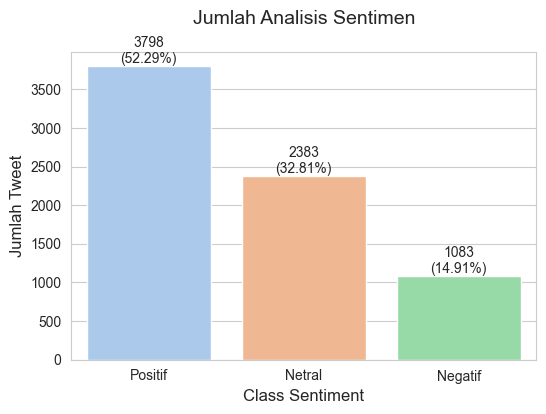

In [50]:
sentiment_count = data['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen', fontsize=14, pad=20)
plt.xlabel('Class Sentiment', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)

total = len(data['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [51]:
data.to_csv('Hasil_Labelling_Data.csv',encoding='utf8', index=False)

# ***Convolutional Neural Networks (CNN)***

In [54]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [55]:
# Load dataset
# Replace with your actual dataset
df = pd.read_csv('Hasil_Labelling_Data.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7264 entries, 0 to 7331
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rating        7264 non-null   int64 
 1   steming_data  7264 non-null   object
 2   Score         7264 non-null   int64 
 3   Sentiment     7264 non-null   object
dtypes: int64(2), object(2)
memory usage: 283.8+ KB


,Rating,steming_data,Score,Sentiment
0,1,mesan obat kendari sulawesi tenggara sedia apo...,0,Netral
1,5,bantu mana sakit untung halodoc bantu kasih sa...,-2,Negatif
2,5,dokter bantu,0,Netral
3,5,bantu kendala berkonsuktas dokter tatap muka,1,Positif
4,5,ramah ramah dokter,0,Netral


In [56]:
data = pd.DataFrame(df[['Rating','steming_data','Sentiment']])
data.head()

,Rating,steming_data,Sentiment
0,1,mesan obat kendari sulawesi tenggara sedia apo...,Netral
1,5,bantu mana sakit untung halodoc bantu kasih sa...,Negatif
2,5,dokter bantu,Netral
3,5,bantu kendala berkonsuktas dokter tatap muka,Positif
4,5,ramah ramah dokter,Netral


In [57]:
# Assuming 'steming_data' is the feature and 'Sentiment' is the target
texts = df['steming_data'].astype(str)
labels = df['Sentiment']

In [58]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
y = to_categorical(encoded_labels)

In [59]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=100, padding='post')

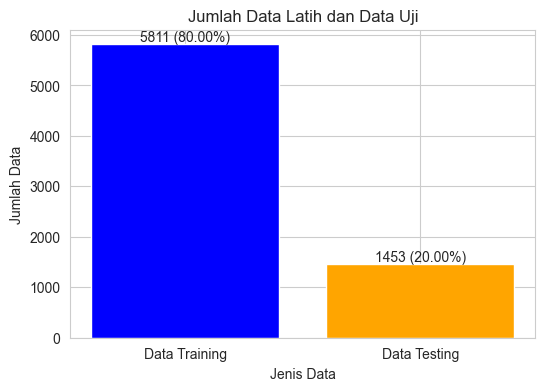

In [60]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = len(X_train)
test_size = len(X_test)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Data Training', 'Data Testing'], [train_size, test_size], color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height} ({height / (train_size + test_size) * 100:.2f}%)',
             ha='center', va='bottom')

plt.title('Jumlah Data Latih dan Data Uji')
plt.xlabel('Jenis Data')
plt.ylabel('Jumlah Data')
plt.show()

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5811, 100)
(5811, 3)
(1453, 100)
(1453, 3)


In [62]:
# Define CNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Assuming 3 sentiment classes (modify if needed)

In [63]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
146/146 [==============================] - 2s 13ms/step - loss: 0.7452 - accuracy: 0.6799 - val_loss: 0.3957 - val_accuracy: 0.8581
Epoch 2/10
146/146 [==============================] - 2s 12ms/step - loss: 0.2828 - accuracy: 0.8969 - val_loss: 0.3230 - val_accuracy: 0.8805
Epoch 3/10
146/146 [==============================] - 2s 11ms/step - loss: 0.1391 - accuracy: 0.9548 - val_loss: 0.3134 - val_accuracy: 0.9003
Epoch 4/10
146/146 [==============================] - 2s 13ms/step - loss: 0.0605 - accuracy: 0.9806 - val_loss: 0.3351 - val_accuracy: 0.8942
Epoch 5/10
146/146 [==============================] - 2s 12ms/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.4413 - val_accuracy: 0.9003
Epoch 6/10
146/146 [==============================] - 2s 11ms/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.4692 - val_accuracy: 0.8848
Epoch 7/10
146/146 [==============================] - 2s 12ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.5399 - val_accuracy: 0.8891

In [64]:
# Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

46/46 [==============================] - 0s 4ms/step


In [65]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy (desimal): {accuracy:.2f}')
print(f'Accuracy (persen): {accuracy * 100:.2f}%')
print('')

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

Accuracy (desimal): 0.89
Accuracy (persen): 88.78%

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.91      0.72      0.80       225
      Netral       0.79      0.92      0.85       483
     Positif       0.96      0.92      0.94       745

    accuracy                           0.89      1453
   macro avg       0.89      0.85      0.86      1453
weighted avg       0.90      0.89      0.89      1453



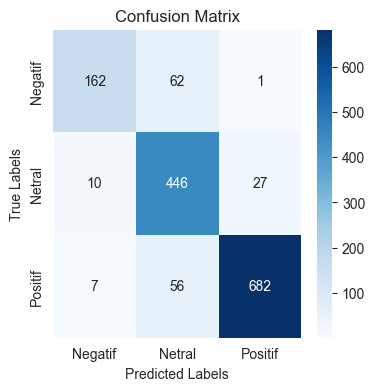

In [66]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

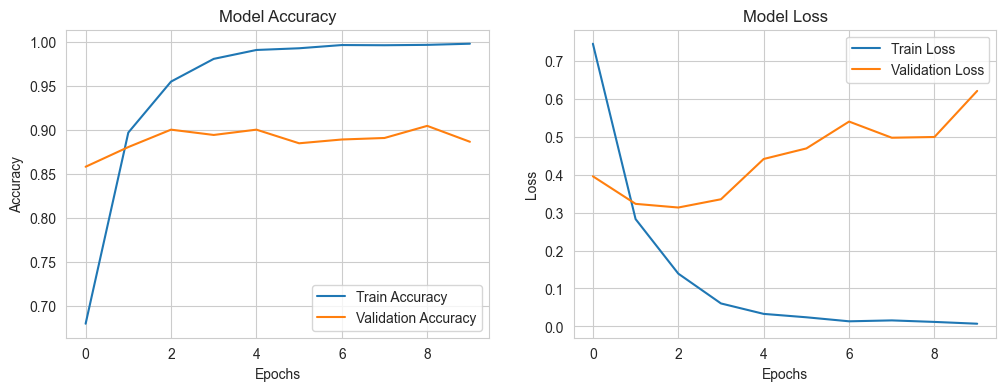

In [67]:
# Plot Accuracy and Loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [68]:
actual_labels = label_encoder.inverse_transform(y_true)
predicted_labels = label_encoder.inverse_transform(y_pred)

data = df.iloc[X_test.shape[0]:].copy()

data = pd.DataFrame({'Rating': df['Rating'].iloc[X_train.shape[0]:],
                   'steming_data': df['steming_data'].iloc[X_train.shape[0]:],
                   'Sentiment': actual_labels,
                   'Predicted': predicted_labels})

data.to_csv('hasil_klasifikasi.csv', index=False)
data.head()

,Rating,steming_data,Sentiment,Predicted
5811,5,mantap,Positif,Positif
5812,4,membantusebelum periksa langsung dokter,Negatif,Negatif
5813,5,bagus jelas ya dokter ya ramah,Positif,Positif
5814,5,bantu desak,Netral,Netral
5815,5,bagustapi,Netral,Netral


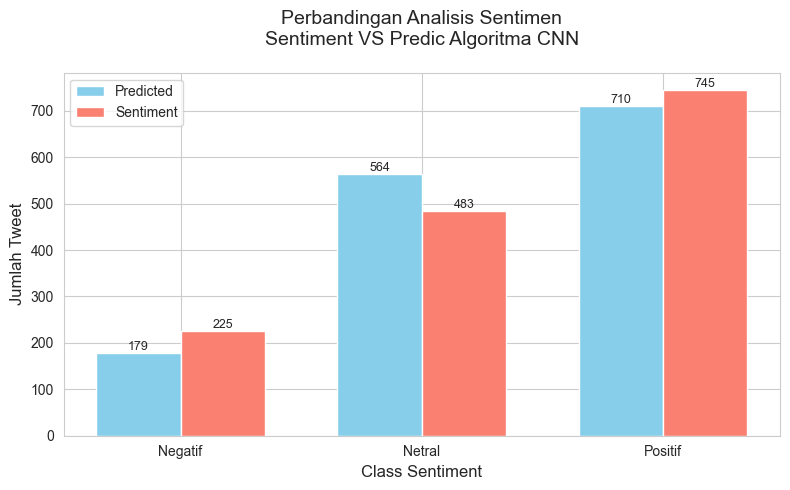

In [69]:
predicted_counts = data['Sentiment'].value_counts().sort_index()
actual_counts = data['Predicted'].value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Predicted': actual_counts,
    'Sentiment': predicted_counts
}).fillna(0)

# Buat plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
index = range(len(comparison_df))

# Plot Actual
ax.bar([i - bar_width/2 for i in index], comparison_df['Predicted'], width=bar_width, label='Predicted', color='skyblue')

# Plot Predicted
ax.bar([i + bar_width/2 for i in index], comparison_df['Sentiment'], width=bar_width, label='Sentiment', color='salmon')

# Set label dan title
ax.set_xlabel('Class Sentiment', fontsize=12)
ax.set_ylabel('Jumlah Tweet', fontsize=12)
ax.set_title('Perbandingan Analisis Sentimen\nSentiment VS Predic Algoritma CNN', fontsize=14, pad=20)
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index)
ax.legend()

# Tambahkan jumlah di atas bar
for i in index:
    actual = comparison_df['Predicted'].iloc[i]
    predicted = comparison_df['Sentiment'].iloc[i]
    ax.text(i - bar_width/2, actual + 0.01, int(actual), ha='center', va='bottom', fontsize=9)
    ax.text(i + bar_width/2, predicted + 0.01, int(predicted), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ***RANTING***

In [70]:
data = pd.read_csv("Hasil_Labelling_Data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7264 entries, 0 to 7263
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rating        7264 non-null   int64 
 1   steming_data  7264 non-null   object
 2   Score         7264 non-null   int64 
 3   Sentiment     7264 non-null   object
dtypes: int64(2), object(2)
memory usage: 227.1+ KB


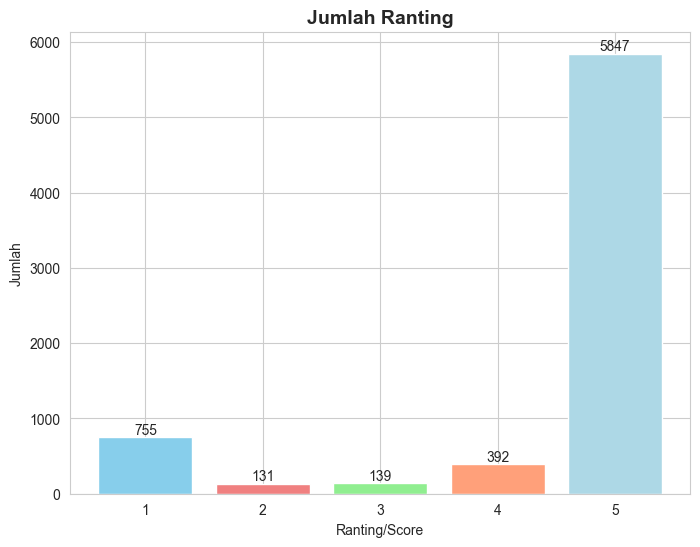

In [71]:
rating_counts = data['Rating'].value_counts()
rating_counts = rating_counts.sort_index()

colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightblue']

plt.figure(figsize=(8, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, color=colors)
plt.title('Jumlah Ranting', fontsize=14, fontweight='bold')
plt.xlabel('Ranting/Score')
plt.ylabel('Jumlah')
plt.xticks(rating_counts.index)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

plt.show()